In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import xarray as xr

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [105]:
ds_sst = xr.open_dataset("../reanalysis_data/NAtl_sst.nc")['sst']
ds_sss = xr.open_dataset("../reanalysis_data/NAtl_sss.nc")['__xarray_dataarray_variable__']

In [106]:
lat_weighted_sst = ds_sst*np.cos(ds_sst.lat*np.pi/180)
lat_weighted_sss = ds_sss*np.cos(ds_sss.lat*np.pi/180)

In [107]:
lat_weighted_sst.shape

(1788, 31, 112)

In [108]:
def deseason(ds):
    yrs = int(len(ds.time)/12)
    
    data = ds.values
    monthly_means = np.zeros((yrs,12,data.shape[1],data.shape[2]))
    
    print()
    
    iyr = 0
    for it in range(len(ds.time)):
        mo_ind = it%12
        monthly_means[iyr,mo_ind,:,:] = data[it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=0)
 
    data_deseason = np.zeros(data.shape)
    for it in range(len(ds.time)):
        mo_ind = it%12
        data_deseason[it,:,:] = data[it,:,:] - monthly_means[mo_ind,:,:]

    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

In [109]:
sst_deseasoned = deseason(lat_weighted_sst)
sss_deseasoned = deseason(lat_weighted_sss)

<ipython-input-108-49a93ec09017>:15: RuntimeWarning: Mean of empty slice
  monthly_means = np.nanmean(monthly_means,axis=0)


In [131]:
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)

In [132]:
np.min(sst_normed)

-14.803975662245898

In [133]:
sst_normed.shape

(1788, 31, 112)

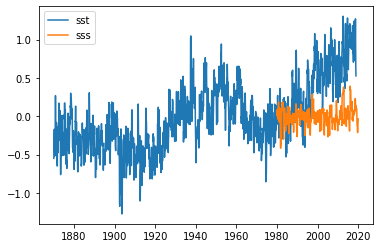

In [134]:
plt.plot(ds_sst.time,np.mean(sst_normed,axis=(1,2)))
plt.plot(ds_sss.time,np.mean(sss_normed,axis=(1,2)))
plt.legend(['sst','sss'])

In [135]:
# use 12 month lag

sst_lag = sst_normed[1320:-12, :, :] # slice lagged sst from 1980-Jan to 2017-Dec
sss_lag = sss_normed[0:-24, :, :]    # slice lagged sss from 1980-Jan to 2017-Dec
sst_lead = sst_normed[-456:, :, :]   # slice lead sst from 1981-Jan to 2018-Dec

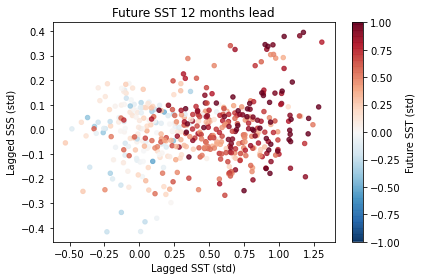

In [137]:
sc = plt.scatter(np.mean(sst_lag,axis=(1,2)),
                 np.mean(sss_lag,axis=(1,2)),
                 c=np.mean(sst_lead,axis=(1,2)),vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)

plt.colorbar(sc,label='Future SST (std)')

plt.xlabel('Lagged SST (std)')
plt.ylabel('Lagged SSS (std)')
plt.title('Future SST '+str(12)+' months lead')
plt.tight_layout()
#plt.savefig('colored_scatter_data.pdf')
plt.show()

In [138]:
model = torch.load('FNN_Adam_MSE')

In [139]:
model

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=258, bias=True)
  (3): ReLU()
  (4): Linear(in_features=258, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=512, out_features=1, bias=True)
)

In [140]:
y = np.mean(sst_lead,axis=(1,2)).reshape(456,1)

X = np.array( [np.mean(sst_lag,axis=(1,2)),np.mean(sss_lag,axis=(1,2)),] ).T

In [141]:
X_val = torch.from_numpy( X.astype(np.float32) )
y_val = torch.from_numpy( y.astype(np.float32) )

Text(0, 0.5, 'Actual')

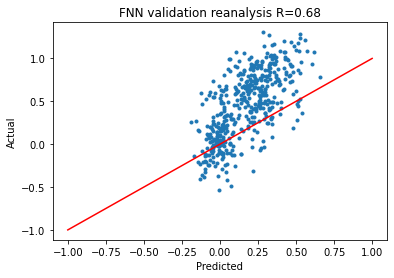

In [143]:
plt.plot(model(X_val).detach().numpy(), y_val.detach().numpy(), '.')
plt.plot( [-1,1],[-1,1] ,'r-')

plt.title('FNN validation reanalysis R='+ \
          str(round( np.corrcoef( y_val.detach().numpy().T, model(X_val).detach().numpy().T )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [155]:
percent_train = 0.8

X_train = torch.from_numpy( X[0:int(np.floor(percent_train*456)), :].astype(np.float32) )
y_train = torch.from_numpy( y[0:int(np.floor(percent_train*456)), :].astype(np.float32) )

X_val = torch.from_numpy( X[int(np.floor(percent_train*456)):, :].astype(np.float32) )
y_val = torch.from_numpy( y[int(np.floor(percent_train*456)):, :].astype(np.float32) )

In [159]:
batch_size = 64
max_epochs = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle = True)

In [160]:
model = nn.Sequential(
          nn.Linear(in_features=2,out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64,out_features=258),
          nn.ReLU(),  
          nn.Linear(in_features=258,out_features=512),
          nn.ReLU(),  
          nn.Dropout(p=0.5),
          nn.Linear(in_features=512,out_features=1))

opt = torch.optim.Adam(model.parameters())
#opt = torch.optim.Adadelta(model.parameters())
loss_fn = nn.MSELoss()

In [161]:
epo_train_losses = [loss_fn(model(X_train),y_train)]
epo_val_losses = [loss_fn(model(X_val),y_val)]

for iepoch in tqdm(range(max_epochs)):
    
    batch_train_losses = []
    model.train()
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch.squeeze())
        batch_train_losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
    epo_train_losses.append( sum(batch_train_losses)/len(batch_train_losses) )

    batch_val_losses = []
    with torch.set_grad_enabled(False):
        for x_batch_val, y_batch_val in val_loader:
            y_pred = model(x_batch_val)
            loss = loss_fn(y_pred.squeeze(), y_batch_val.squeeze())
            batch_val_losses.append(loss.item())
        epo_val_losses.append( sum(batch_val_losses)/len(batch_val_losses) )

100%|██████████| 10/10 [00:00<00:00, 61.53it/s]


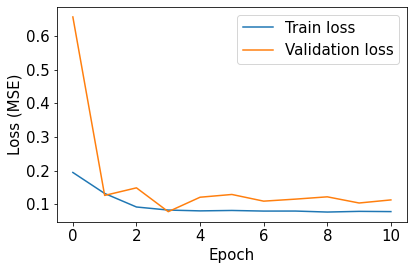

In [162]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 15})

plt.plot(epo_train_losses)
plt.plot(epo_val_losses)
plt.legend(['Train loss','Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.tight_layout()

#plt.savefig('loss_at_epoch.pdf')
plt.show()

In [163]:
model.eval()

y_pred_val = model(X_val).detach().numpy()
y_val = y_val.detach().numpy()

y_pred_train = model(X_train).detach().numpy()
y_train = y_train.detach().numpy()

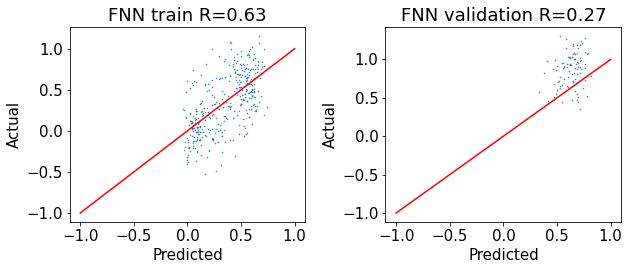

In [165]:
plt.figure(figsize=(9,4))
plt.rcParams.update({'font.size': 15})

plt.subplot(121)
plt.plot( y_pred_train,y_train,'.',markersize=1 )
plt.plot( [-1,1],[-1,1] ,'r-')
#plt.xlim([-1,1])
#plt.ylim([-1,1])
plt.title('FNN train R='+ str(round(np.corrcoef( y_pred_train.T[0,:], y_train.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(122)
plt.plot( y_pred_val,y_val,'.', markersize=1)
plt.plot( [-1,1],[-1,1] ,'r-')
#plt.xlim([-1,1])
#plt.ylim([-1,1])
plt.title('FNN validation R='+ str(round( np.corrcoef( y_pred_val.T[0,:], y_val.T[0,:] )[0,1],2)))
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()

#plt.savefig('train_validation_correlation.pdf')

plt.show()